# 完全ネットワーク上での実験

In [1]:
using Random: MersenneTwister, shuffle
using StatsBase: mean, std, sample, Weights

include("../src/Simulation.jl")
using Main.Simulation: Strategy, C, D, invert, sigmoid_fitness

In [2]:
@kwdef struct Param
    N::Int = 100
    T::Float64 = 1.1            # Temptation payoff
    S::Float64 = -0.1           # Sucker's payoff
    reproduction_rate::Float64 = 0.05
    δ::Float64 = 1.0            # strength of selection
    μ::Float64 = 0.01           # mutatino rate
    t_max::Int = 1_000          # time steps
    trial_max::Int = 100
    rng::MersenneTwister = MersenneTwister() # random seed
end

mutable struct Model
    param::Param
    payoff_table::Dict
    reproduction_N::Int

    # agent's parameters
    strategy_vec::Vector{Strategy}     # agents' strategy
    payoff_vec::Vector{Float64}        # agents' payoff

    function Model(param::Param)
        new(
            param,
            Dict((C, C) => (1.0, 1.0), (C, D) => (param.S, param.T), (D, C) => (param.T, param.S), (D, D) => (0.0, 0.0)),
            round(Int, param.N * param.reproduction_rate),

            # agent's parameters
            # fill(D, param.N),
            rand(param.rng, [C, D], param.N),
            fill(0.0, param.N)
        )
    end
end

cooperation_rate(model::Model)::Float64 = sum(model.strategy_vec .== C) / model.param.N

param_to_tuple(param::Param)::Tuple = param.N, param.T, param.S, param.reproduction_rate, param.δ, param.μ, param.t_max, param.trial_max

param_to_str(param::Param)::String = join(param_to_tuple(param), ", ")

function interaction!(model::Model, rng::MersenneTwister)::Nothing
    model.payoff_vec .= 0.0
    focal_id_vec = collect(1:model.param.N)
    opponent_id_vec = shuffle(rng, 1:model.param.N)

    for (focal_id, opponent_id) in zip(focal_id_vec, opponent_id_vec)
        if focal_id == opponent_id
            opponent_id = (opponent_id + 1) % model.param.N + 1
        end

        # strategy
        strategy_pair = (model.strategy_vec[focal_id], model.strategy_vec[opponent_id])

        # payoff
        focal_payoff, opponent_payoff = model.payoff_table[strategy_pair]
        model.payoff_vec[focal_id] += focal_payoff
        model.payoff_vec[opponent_id] += opponent_payoff
    end

    return
end

function pick_deaths(model::Model, rng::MersenneTwister)::Vector{Int}
    neg_fitness_vec = sigmoid_fitness.(-model.payoff_vec, model.param.δ)
    death_id_vec = sample(rng, 1:model.param.N, Weights(neg_fitness_vec), model.reproduction_N, replace = false)

    return death_id_vec
end

function pick_parents(model::Model, rng::MersenneTwister)::Vector{Int}
    fitness_vec = sigmoid_fitness.(model.payoff_vec, model.param.δ)
    parent_id_vec = sample(rng, 1:model.param.N, Weights(fitness_vec), model.reproduction_N, replace = false)

    return parent_id_vec
end

function death_birth!(model::Model, rng::MersenneTwister)::Tuple{Vector{Int}, Vector{Int}}
    parent_id_vec = pick_parents(model, rng)
    death_id_vec = pick_deaths(model, rng)

    for (parent_id, child_id) in zip(parent_id_vec, death_id_vec)
        model.strategy_vec[child_id] = rand(rng) > model.param.μ ? model.strategy_vec[parent_id] : invert(model.strategy_vec[parent_id])
    end

    return parent_id_vec, death_id_vec
end

function run_one_step!(model::Model)::Nothing
    interaction!(model, model.param.rng)
    death_birth!(model, model.param.rng)
    return
end

function run(param::Param)::Matrix{Float64}
    cooperation_rate_matrix = fill(0.0, param.t_max, param.trial_max)

    for trial in 1:param.trial_max
        model = Model(param)
        for t in 1:model.param.t_max
            run_one_step!(model)
            cooperation_rate_matrix[t, trial] = cooperation_rate(model)
        end
    end

    return cooperation_rate_matrix
end;

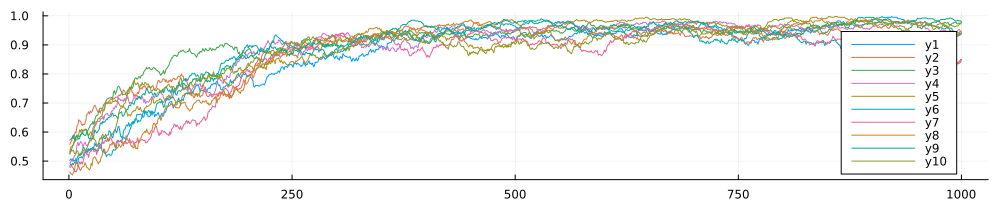

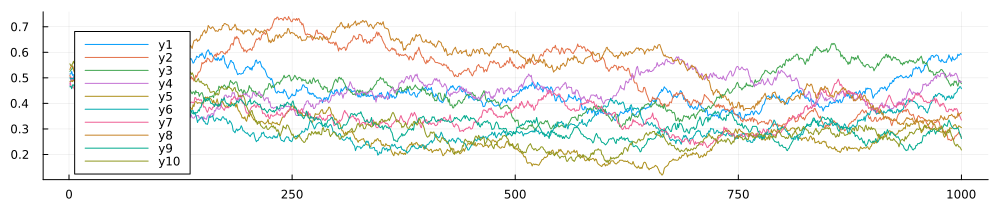

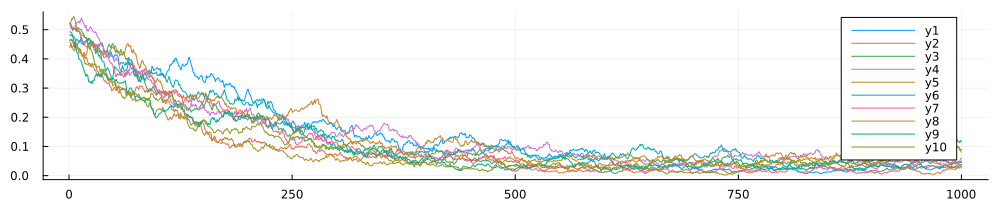

In [3]:
using Plots: plot, plot!, Plot

function plot_time_series(cooperation_rate_matrix::Matrix{Float64})::Plot
    t_max, trial_max = size(cooperation_rate_matrix)

    p = plot(size = (1000, 200))
    
    for trial in 1:trial_max
        plot!(cooperation_rate_matrix[:, trial])
    end
    
    return p
end

param = Param(N = 400, T = 0.9, S = 0.1, trial_max = 10)
cooperation_rate_matrix = run(param)
display(plot_time_series(cooperation_rate_matrix))

param = Param(N = 400, T = 1.0, S = 0.0, trial_max = 10)
cooperation_rate_matrix = run(param)
display(plot_time_series(cooperation_rate_matrix))

param = Param(N = 400, T = 1.1, S = -0.1, trial_max = 10)
cooperation_rate_matrix = run(param)
display(plot_time_series(cooperation_rate_matrix))

In [ ]:
N_vec = [250, 500]
T_vec = 0.0:0.1:2.0
S_vec = -1.0:0.1:1.0
δ_vec = [1.0]
μ_vec = [0.01]

@time open("result.csv", "w") do io
    write(io, "N,T,S,reproduction_rate,δ,μ,t_max,trial_max,mean_cooperation,std_cooperation\n")

    for N in N_vec, T in T_vec, S in S_vec, δ in δ_vec
        param = Param(N = N, T = T, S = S, δ = δ, t_max = N * 2, trial_max = 10, rng = MersenneTwister(1))
        cooperation_rate_matrix = run(param)
        cooperation_rate_vec = vec(mean(cooperation_rate_matrix[end-99:end, :], dims=1))
        write(io, "$(param_to_str(param)), $(mean(cooperation_rate_vec)), $(std(cooperation_rate_vec))\n")
    end
end

LoadError: InterruptException: